In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("./preprocessed_Training_dataset.csv")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE

In [6]:
X_train = df.drop(columns=['Reservation_Status'])
y_train = df['Reservation_Status']

In [7]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [8]:
y_train_split = y_train_split - np.min(y_train_split)
y_val_split = y_val_split - np.min(y_val_split)

In [9]:
print("Unique classes in y_train_split:", np.unique(y_train_split))
print("Unique classes in y_val_split:", np.unique(y_val_split))

Unique classes in y_train_split: [0 1 2]
Unique classes in y_val_split: [0 1 2]


In [10]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

In [11]:
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, min_child_weight=5, reg_lambda=5, reg_alpha=2, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(
        iterations=200, learning_rate=0.05, depth=3, l2_leaf_reg=15, verbose=0, 
        bagging_temperature=1,
        early_stopping_rounds=50,
        auto_class_weights='Balanced',
        random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
    
}

In [12]:
f1_scores = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = model.predict(X_val_split)
    f1 = f1_score(y_val_split, y_pred, average='weighted')
    f1_scores[name] = f1

    print(f"{name} - F1 Score: {f1}")
    print(classification_report(y_val_split, y_pred))
    print("=" * 60)

Training Random Forest...
Random Forest - F1 Score: 0.818580987610899
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4267
           1       0.57      0.54      0.55       810
           2       0.50      0.39      0.44       423

    accuracy                           0.82      5500
   macro avg       0.65      0.62      0.63      5500
weighted avg       0.81      0.82      0.82      5500

Training Gradient Boosting...
Gradient Boosting - F1 Score: 0.8219709795603106
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4267
           1       0.56      0.55      0.55       810
           2       0.43      0.56      0.49       423

    accuracy                           0.82      5500
   macro avg       0.64      0.67      0.65      5500
weighted avg       0.83      0.82      0.82      5500

Training XGBoost...
XGBoost - F1 Score: 0.8237003617961736
              precision    rec

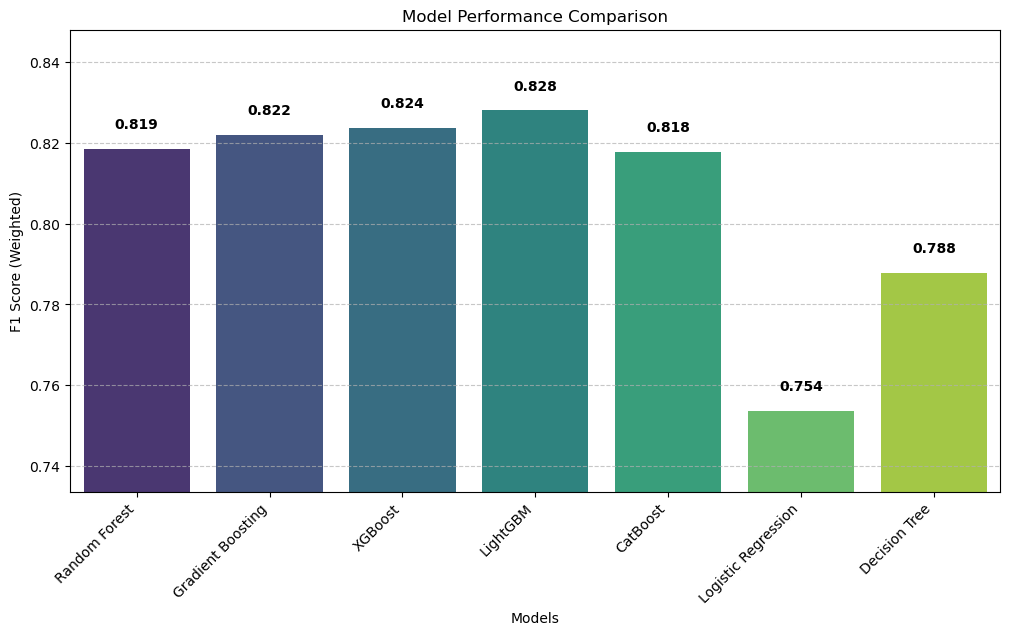

In [13]:
import numpy as np

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")

plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 Score (Weighted)")
plt.xlabel("Models")
plt.title("Model Performance Comparison")

min_f1 = min(f1_scores.values())
max_f1 = max(f1_scores.values())

plt.ylim(min_f1 - 0.02, max_f1 + 0.02)

for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("Model Performance Comparision", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
val_df = pd.read_csv("./preprocessed_validation_dataset.csv")

In [15]:
X_val = val_df.drop(columns=['Reservation_Status'])
y_val = val_df['Reservation_Status']

y_val = y_val.replace({1: 0, 2: 1, 3: 2})

print("\n===== Model Evaluation on Validation Set =====\n")
for name, model in models.items():
    print(f"Evaluating {name}...")
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    print(f"{name} - F1 Score: {f1}")
    print(classification_report(y_val, y_val_pred))
    print("=" * 60)  



===== Model Evaluation on Validation Set =====

Evaluating Random Forest...
Random Forest - F1 Score: 0.64674751643067
              precision    recall  f1-score   support

           0       0.71      0.93      0.81      1610
           1       0.66      0.38      0.48       741
           2       0.44      0.24      0.31       398

    accuracy                           0.68      2749
   macro avg       0.60      0.52      0.53      2749
weighted avg       0.66      0.68      0.65      2749

Evaluating Gradient Boosting...
Gradient Boosting - F1 Score: 0.6731178675042119
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1610
           1       0.75      0.34      0.47       741
           2       0.41      0.49      0.45       398

    accuracy                           0.69      2749
   macro avg       0.64      0.58      0.58      2749
weighted avg       0.70      0.69      0.67      2749

Evaluating XGBoost...
XGBoost - F1 Sc

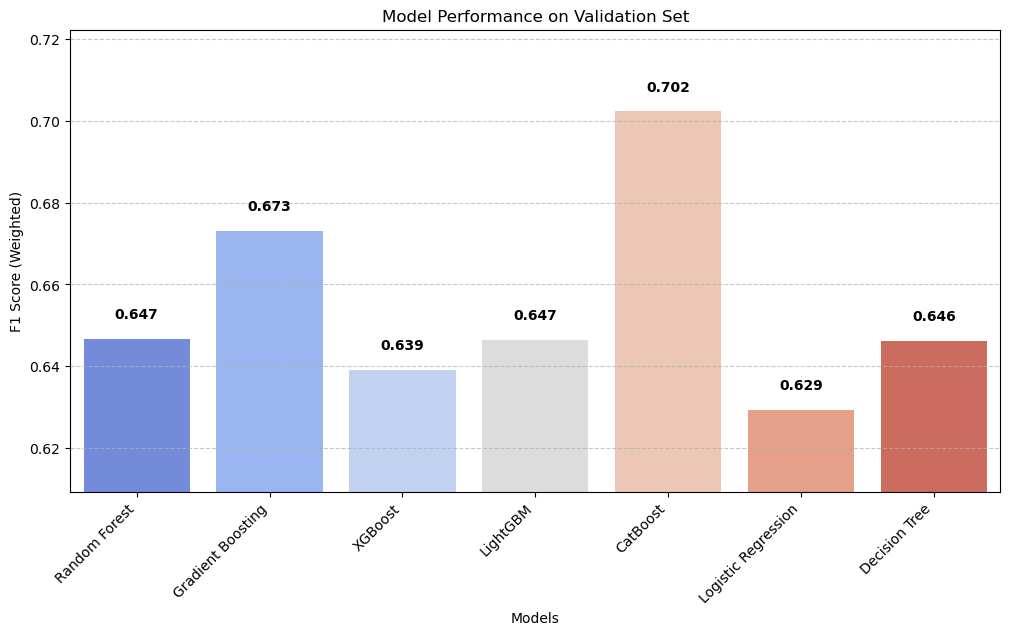

In [16]:
X_val = val_df.drop(columns=['Reservation_Status'])
y_val = val_df['Reservation_Status']

y_val = y_val.replace({1: 0, 2: 1, 3: 2})

val_f1_scores = {}

for name, model in models.items():
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_f1_scores[name] = f1  

plt.figure(figsize=(12, 6))
sns.barplot(x=list(val_f1_scores.keys()), y=list(val_f1_scores.values()), palette="coolwarm")

plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 Score (Weighted)")
plt.xlabel("Models")
plt.title("Model Performance on Validation Set")

min_f1 = min(val_f1_scores.values())
max_f1 = max(val_f1_scores.values())
plt.ylim(min_f1 - 0.02, max_f1 + 0.02)

for i, v in enumerate(val_f1_scores.values()):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("Model Performance On Validation Set", dpi=300, bbox_inches="tight")
plt.show()



Class: Class 1
True Positives (TP): 1392
False Positives (FP): 323
False Negatives (FN): 218
True Negatives (TN): 816

Class: Class 2
True Positives (TP): 328
False Positives (FP): 154
False Negatives (FN): 413
True Negatives (TN): 1854

Class: Class 3
True Positives (TP): 221
False Positives (FP): 331
False Negatives (FN): 177
True Negatives (TN): 2020


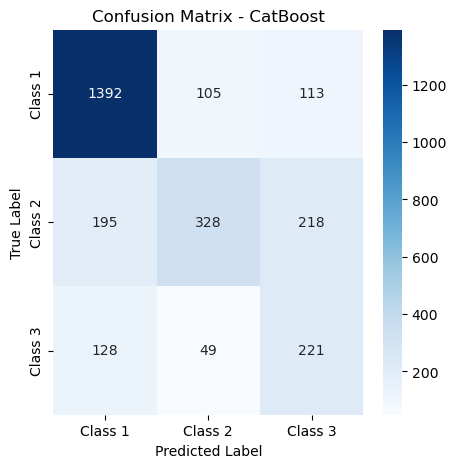

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_labels = ["Class 1", "Class 2", "Class 3"]  

catboost_model = models['CatBoost']

y_val_pred = catboost_model.predict(X_val)

cm = confusion_matrix(y_val, y_val_pred)

TP = np.diag(cm) 
FP = np.sum(cm, axis=0) - TP  
FN = np.sum(cm, axis=1) - TP  
TN = np.sum(cm) - (TP + FP + FN)  

for i, label in enumerate(class_labels):
    print(f"\nClass: {label}")
    print(f"True Positives (TP): {TP[i]}")
    print(f"False Positives (FP): {FP[i]}")
    print(f"False Negatives (FN): {FN[i]}")
    print(f"True Negatives (TN): {TN[i]}")

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CatBoost")
plt.show()


## Part 2(b) Customer Segmentation

In [20]:
from sklearn.preprocessing import StandardScaler

features_for_clustering = [
    'Income', 'Ethnicity_African American', 
    'Ethnicity_Asian American', 'Ethnicity_Latino', 'Ethnicity_caucasian', 
    'Stay_Duration',  
    'Visted_Previously', 'Previous_Cancellations', 'Room_Rate', 
    'Discount_Rate', 'Deposit_No Deposit', 'Deposit_Non-Refundable', 
    'Deposit_Refundable', 'Required_Car_Parking', 'Use_Promotion', 
    'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort', 'Channel_Agent', 'Channel_Direct', 
    'Channel_Online'
]

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train[features_for_clustering])
X_val_normalized = scaler.transform(X_val[features_for_clustering])

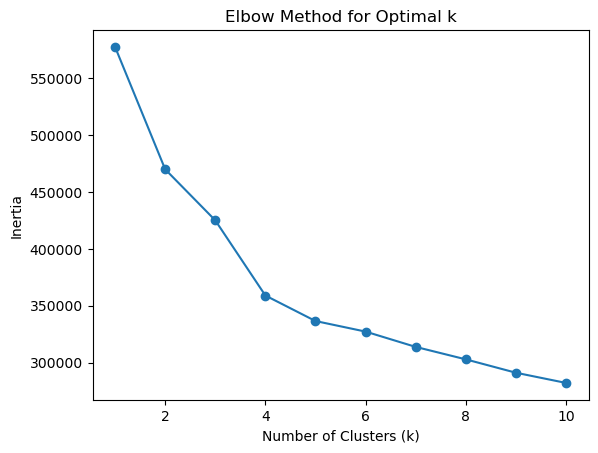

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_normalized)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig("Elbow Method for Optmial k", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train_normalized)

X_train['Cluster'] = kmeans.predict(X_train_normalized)
X_val['Cluster'] = kmeans.predict(X_val_normalized)

In [23]:
cluster_summary = X_train.groupby('Cluster')[features_for_clustering].mean()
pd.set_option("display.max_columns", None)  
print(cluster_summary)

           Income  Ethnicity_African American  Ethnicity_Asian American  \
Cluster                                                                   
0        1.290592                    0.000000                  0.000000   
1        1.295647                    0.000000                  0.000000   
2        1.284909                    0.371189                  0.628659   
3        1.308503                    0.792325                  0.000000   

         Ethnicity_Latino  Ethnicity_caucasian  Stay_Duration  \
Cluster                                                         
0                 1.00000             0.000000       1.841426   
1                 0.00000             1.000000       1.848888   
2                 0.00000             0.000152       1.823476   
3                 0.00015             0.207524       1.830399   

         Visted_Previously  Previous_Cancellations   Room_Rate  Discount_Rate  \
Cluster                                                                      

In [27]:
X_val['Cluster'] = kmeans.predict(X_val_normalized)

val_cluster_summary = X_val.groupby('Cluster')[features_for_clustering].mean()
pd.set_option("display.max_columns", None) 
print(val_cluster_summary)

           Income  Ethnicity_African American  Ethnicity_Asian American  \
Cluster                                                                   
0        1.334940                    0.000000                  0.000000   
1        1.265528                    0.000000                  0.000000   
2        1.269414                    0.381933                  0.616482   
3        1.282609                    0.821429                  0.000000   

         Ethnicity_Latino  Ethnicity_caucasian  Stay_Duration  \
Cluster                                                         
0                1.000000             0.000000       1.781928   
1                0.000000             1.000000       1.809006   
2                0.001585             0.000000       1.851030   
3                0.000000             0.178571       1.753106   

         Visted_Previously  Previous_Cancellations   Room_Rate  Discount_Rate  \
Cluster                                                                      

## Part 2(c) Model Explainability

#### Using Shap


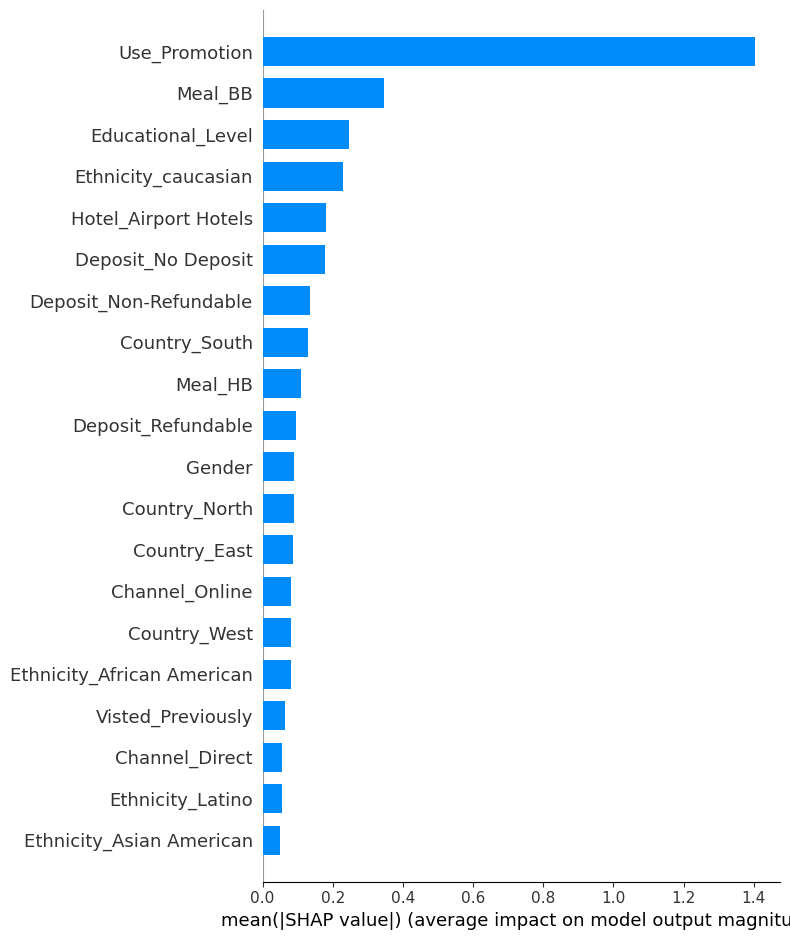

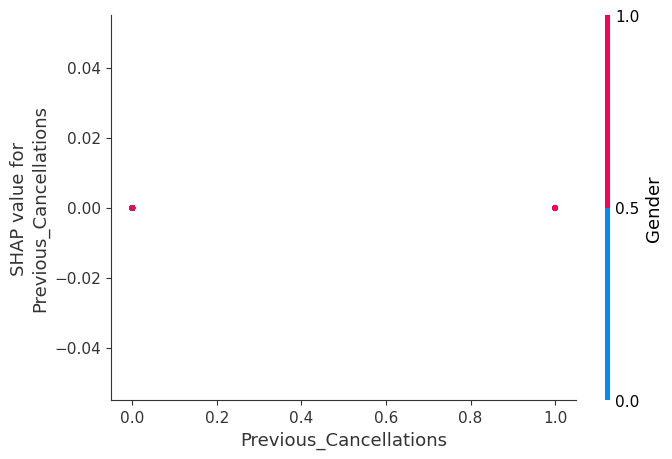

In [33]:
import shap
import numpy as np

explainer = shap.TreeExplainer(models['CatBoost'])
shap_values = explainer.shap_values(X_val_split)

shap_values_selected = shap_values[:, :, 0]  

feature_name = 'Previous_Cancellations'
if feature_name not in X_val_split.columns:
    raise ValueError(f"Feature '{feature_name}' not found in dataset columns: {X_val_split.columns.tolist()}")

plt.figure()
shap.summary_plot(shap_values_selected, X_val_split, plot_type="bar", show=False)
plt.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=300)  
plt.show()

shap.dependence_plot(feature_name, shap_values_selected, X_val_split)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_selected[0], X_val_split.iloc[0])


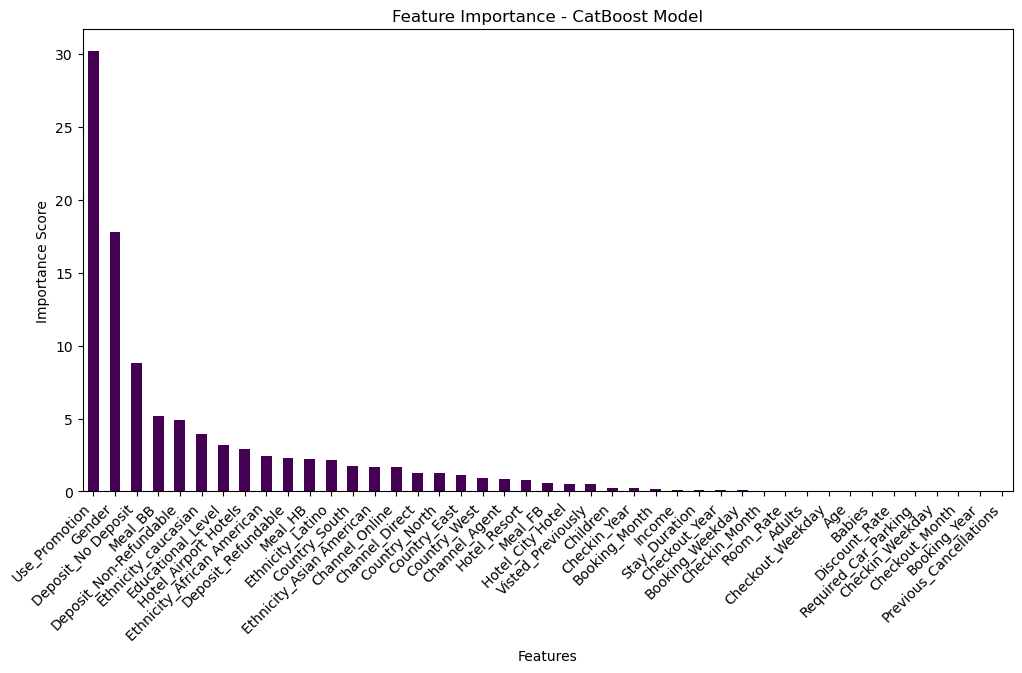

In [36]:
best_catboost = models["CatBoost"]
feature_importance = best_catboost.get_feature_importance()
features = X_train_resampled.columns

plt.figure(figsize=(12, 6))
pd.Series(feature_importance, index=features).sort_values(ascending=False).plot(kind='bar', colormap='viridis')
plt.title("Feature Importance - CatBoost Model")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.show()
